In [ ]:
import pandas as pd
import numpy as np
import random
import json
from geopy.distance import geodesic
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
import os

In [ ]:
# Load dataset
print("Loading data...")
df = pd.read_csv("data_route.csv")
required_cols = ['Delivery_location_latitude', 'Delivery_location_longitude']
if not all(col in df.columns for col in required_cols):
  raise ValueError("Missing required columns.")

Loading data...


In [ ]:
# Define depot and number of clusters
depot_lat = 22.31279
depot_lon = 73.170283
num_clusters = 3

In [ ]:
# KMeans clustering
print("Clustering data...")
coords = df[['Delivery_location_latitude', 'Delivery_location_longitude']].values
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(coords)

Clustering data...


In [ ]:
# Create directory
os.makedirs("route_maps", exist_ok=True)

In [ ]:
# Distance helper
print("Setting up distance matrix function...")
def distance_matrix(location):
  return [[geodesic(location[i], location[j]).km for j in range(len(location))] for i in range(len(location))]

def total_distance(route, dist_matrix):
  return sum(dist_matrix[route[i]][route[i+1]] for i in range(len(route)-1)) + dist_matrix[route[-1]][route[0]]

Setting up distance matrix function...


In [ ]:
# Simulated Annealing
print("Defining SA function...")
def simulated_annealing(dist_matrix, T_init, alpha, T_stop, iterations):
  n = len(dist_matrix)
  current_route = list(range(n))
  random.shuffle(current_route)
  current_distance = total_distance(current_route, dist_matrix)
  best_route = list(current_route)
  best_distance = current_distance
  T = T_init

  while T > T_stop:
    for _ in range(iterations):
      i, j = random.sample(range(1, n), 2)
      new_route = list(current_route)
      new_route[i], new_route[j] = new_route[j], new_route[i]
      new_distance = total_distance(new_route, dist_matrix)
      if new_distance < current_distance or random.random() < np.exp((current_distance - new_distance) / T):
        current_route = new_route
        current_distance = new_distance
        if new_distance < best_distance:
          best_route = new_route
          best_distance = new_distance
    T *= alpha
  return best_route, best_distance

Defining SA function...


In [ ]:
# Random Search to find best SA parameters
print("Running random search for best SA parameters...")
best_config = None
best_total_cost = float('inf')

for trial in range(30):
  config = {
    'T_init': np.random.uniform(1e3, 1e5),
    'alpha': np.random.uniform(0.90, 0.99),
    'T_stop': np.random.uniform(1e-6, 1e-3),
    'iterations': random.randint(100, 1000)
  }
  total_cost = 0
  for driver_id in range(num_clusters):
    group = df[df['Cluster'] == driver_id]
    locations = [(depot_lat, depot_lon)] + list(zip(group['Delivery_location_latitude'], group['Delivery_location_longitude']))
    dist_matrix = distance_matrix(locations)
    _, cost = simulated_annealing(dist_matrix, **config)
    total_cost += cost
  if total_cost < best_total_cost:
    best_total_cost = total_cost
    best_config = config

print("Best SA Parameters:", best_config)

Running random search for best SA parameters...
Best SA Parameters: {'T_init': 10958.267493975134, 'alpha': 0.9336704151597067, 'T_stop': 6.954039407636884e-05, 'iterations': 993}


Comparing models...


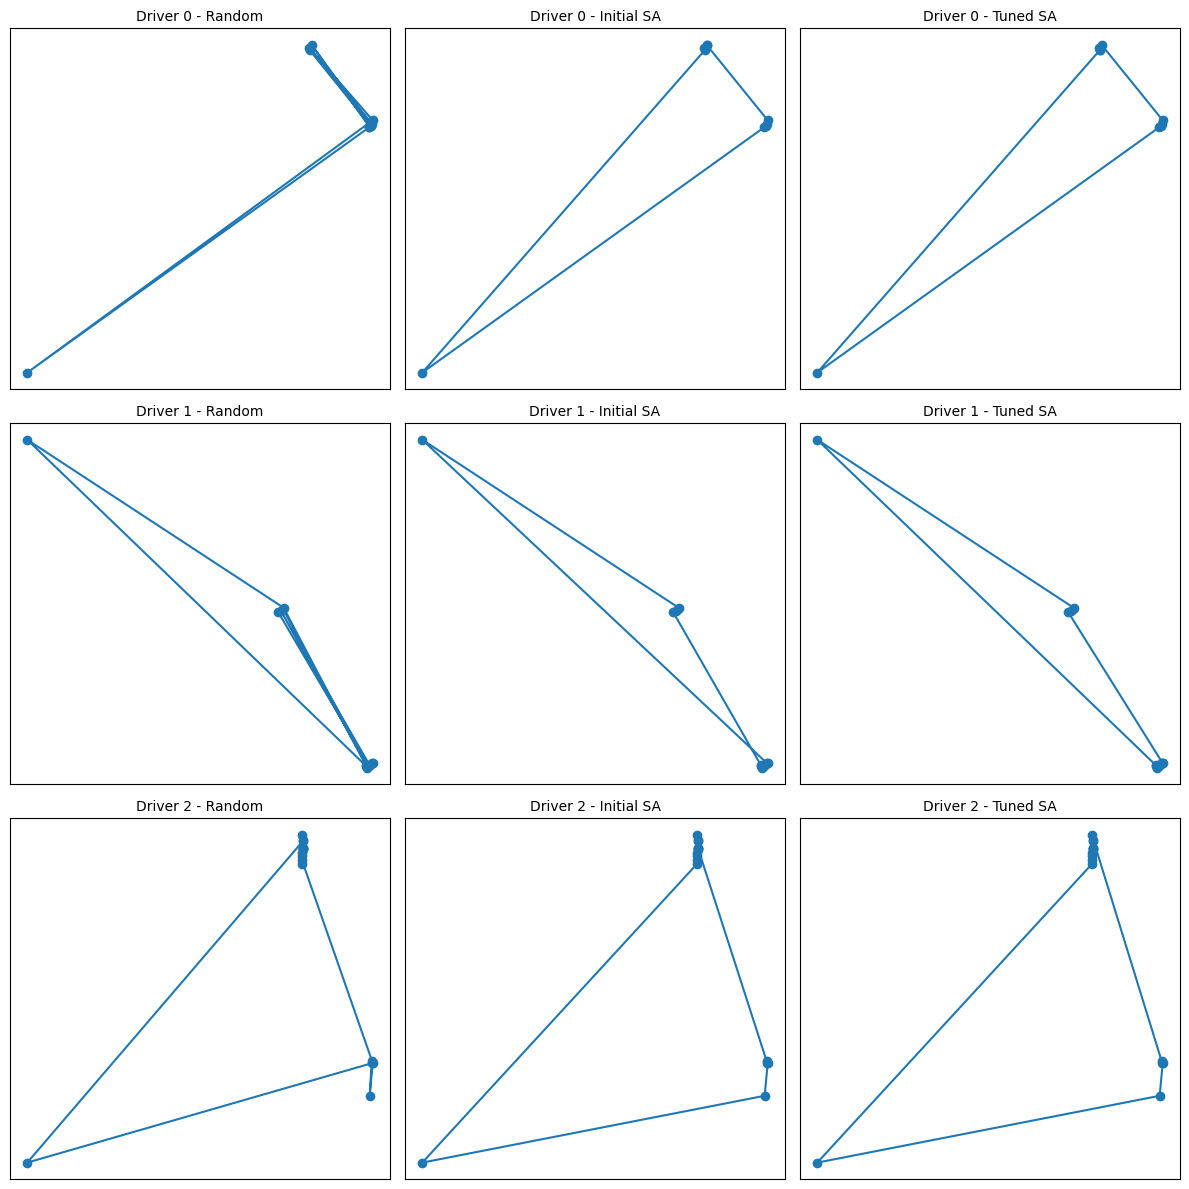


Final Distance Comparison:
   Driver  Random (km)  Initial SA (km)  Tuned SA (km)
0       0      3065.42          2032.03        2032.03
1       1      4772.68          2606.48        2601.73
2       2      3250.65          3190.48        3186.28


In [ ]:
# Final comparison across models
print("Comparing models...")
comparison = []
fig = plt.figure(figsize=(12, 4 * num_clusters))

for driver_id in range(num_clusters):
  group = df[df['Cluster'] == driver_id]
  locations = [(depot_lat, depot_lon)] + list(zip(group['Delivery_location_latitude'], group['Delivery_location_longitude']))
  dist_matrix = distance_matrix(locations)

  # Random Route
  rand_route = list(range(len(locations)))
  random.shuffle(rand_route)
  rand_cost = total_distance(rand_route, dist_matrix)

  # Initial SA
  init_route, init_cost = simulated_annealing(dist_matrix, T_init=10000, alpha=0.95, T_stop=1e-6, iterations=500)

  # Tuned SA
  tuned_route, tuned_cost = simulated_annealing(dist_matrix, **best_config)

  # Plot
  subplot_base = driver_id * 3 + 1
  def plot_route(loc, route, title, pos):
    coords = [loc[i] for i in route] + [loc[route[0]]]
    lats, lons = zip(*coords)
    plt.subplot(num_clusters, 3, pos)
    plt.plot(lons, lats, 'o-', label=title)
    plt.title(title, fontsize=10)
    plt.xticks([])
    plt.yticks([])
  plot_route(locations, rand_route, f"Driver {driver_id} - Random", subplot_base)
  plot_route(locations, init_route, f"Driver {driver_id} - Initial SA", subplot_base + 1)
  plot_route(locations, tuned_route, f"Driver {driver_id} - Tuned SA", subplot_base + 2)

  comparison.append({
    "Driver": driver_id,
    "Random (km)": round(rand_cost, 2),
    "Initial SA (km)": round(init_cost, 2),
    "Tuned SA (km)": round(tuned_cost, 2)
  })

plt.tight_layout()
plt.savefig("final_model_comparison_plot.png")
plt.show()

comparison_df = pd.DataFrame(comparison)
print("\nFinal Distance Comparison:")
print(comparison_df)
comparison_df.to_csv("final_model_comparison.csv", index=False)

In [ ]:
# Folium map of best SA routes
print("Creating folium map for best routes...")
m = folium.Map(location=[df['Delivery_location_latitude'].mean(), df['Delivery_location_longitude'].mean()], zoom_start=10)
colors = ['green', 'blue', 'purple']
for driver_id in range(num_clusters):
  group = df[df['Cluster'] == driver_id]
  locations = [(depot_lat, depot_lon)] + list(zip(group['Delivery_location_latitude'], group['Delivery_location_longitude']))
  dist_matrix = distance_matrix(locations)
  tuned_route, _ = simulated_annealing(dist_matrix, **best_config)
  coords = [locations[i] for i in tuned_route] + [locations[tuned_route[0]]]
  folium.PolyLine(coords, color=colors[driver_id % len(colors)], weight=4).add_to(m)
  for idx, (lat, lon) in enumerate(coords):
    folium.Marker([lat, lon], popup=f"Driver {driver_id} - Stop {idx}").add_to(m)
m.save("final_best_route_map.html")
print("Map saved to final_best_route_map.html")

Creating folium map for best routes...
Map saved to final_best_route_map.html


In [ ]:
m

In [ ]:
for driver_id in range(num_clusters):
    count = df[df['Cluster'] == driver_id].shape[0]
    print(f"Driver {driver_id} has {count} delivery points.")

Driver 0 has 7 delivery points.
Driver 1 has 18 delivery points.
Driver 2 has 14 delivery points.
